In [4]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from itertools import combinations
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import shap



In [5]:
crops = pd.read_csv('soil_measures.csv')

In [6]:


# Encode the target variable
label_encoder = LabelEncoder()
crops["crop"] = label_encoder.fit_transform(crops["crop"])

# Split the data with the final features
final_features = ["N", "ph", "K", "P"]
X_train, X_test, y_train, y_test = train_test_split(
    crops[final_features],
    crops["crop"],
    test_size=0.2,
    random_state=10
)

# Define the models
rf = RandomForestClassifier(random_state=10)
gr = GradientBoostingClassifier(random_state=10)
XGB = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=10)
dt = DecisionTreeClassifier(random_state=10)


In [7]:

# Train the VotingClassifier
vc = VotingClassifier(estimators=[('rf', rf), ('gr', gr), ('XGB', XGB), ('dt', dt)], voting='hard')
vc.fit(X_train, y_train)
vc_pred = vc.predict(X_test)
model_performance_vc = accuracy_score(y_test, vc_pred)
print('Voting Classifier\'s model performance: '  + str(model_performance_vc))

# Extract and print feature importances from the individual classifiers that support it
feature_importances = {}

# RandomForest
if hasattr(rf, 'feature_importances_'):
    feature_importances['RandomForest'] = rf.feature_importances_

# GradientBoosting
if hasattr(gr, 'feature_importances_'):
    feature_importances['GradientBoosting'] = gr.feature_importances_

# XGBoost
if hasattr(XGB, 'feature_importances_'):
    feature_importances['XGBoost'] = XGB.feature_importances_

# Print the feature importances
for model_name, importances in feature_importances.items():
    print(f"Feature importances for {model_name}:")
    for feature, importance in zip(final_features, importances):
        print(f"  {feature}: {importance}")

# Extract the fitted XGB model from the VotingClassifier
fitted_xgb = vc.named_estimators_['XGB']


Voting Classifier's model performance: 0.8204545454545454


Shape of shap_values: (440, 4, 22)
Shape of X_test: (440, 4)
Class 0 (apple)


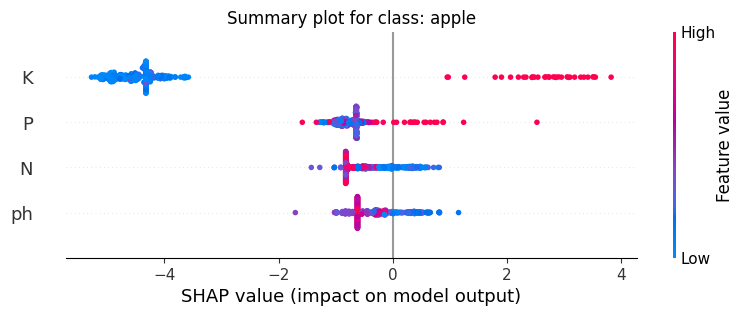

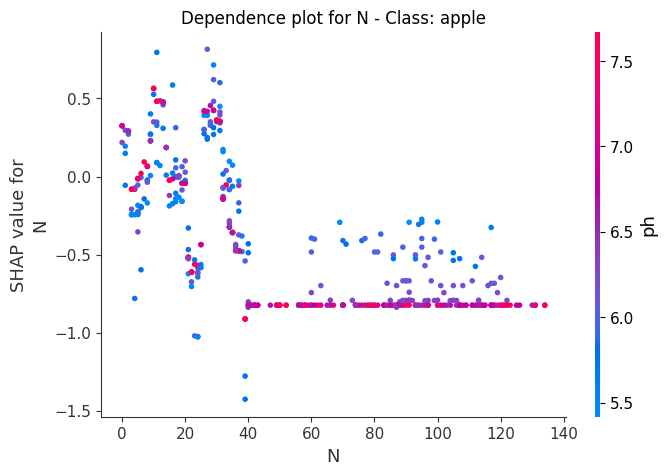

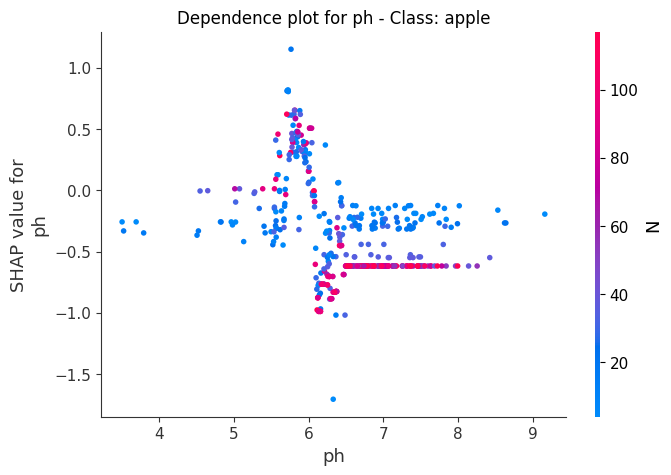

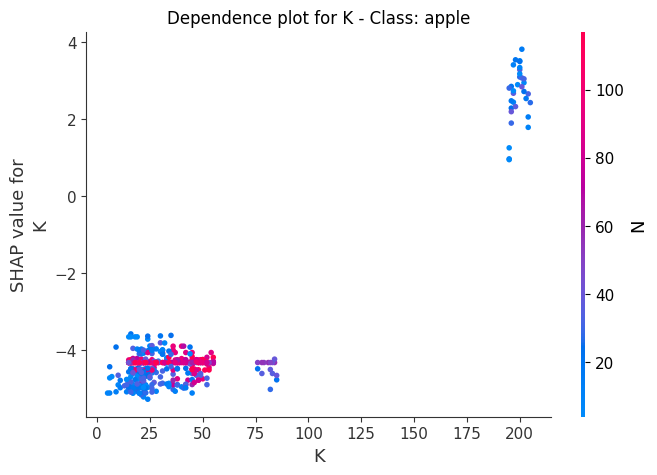

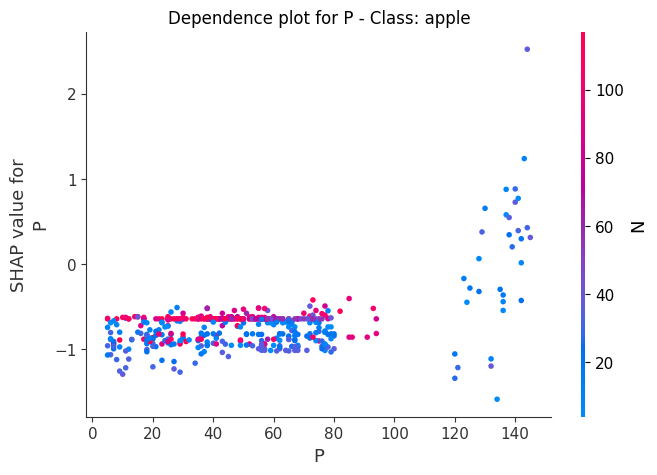

Class 1 (banana)


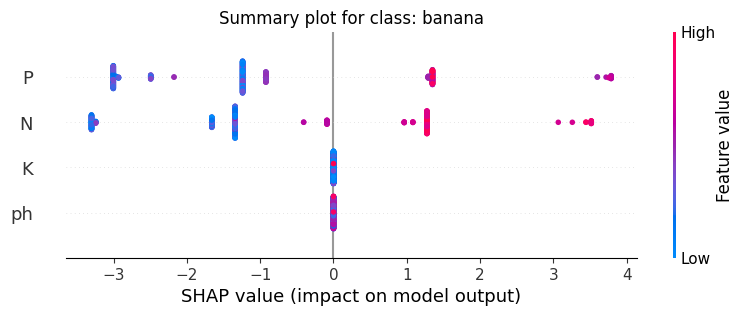

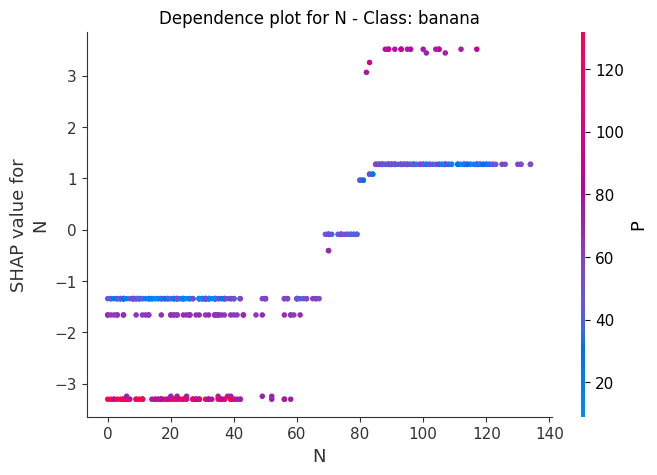

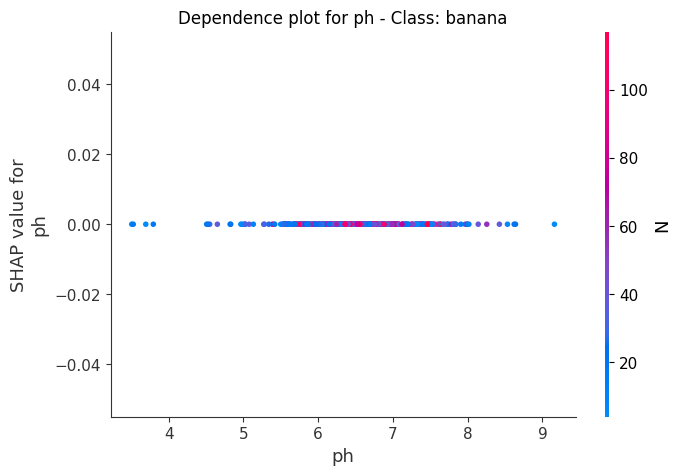

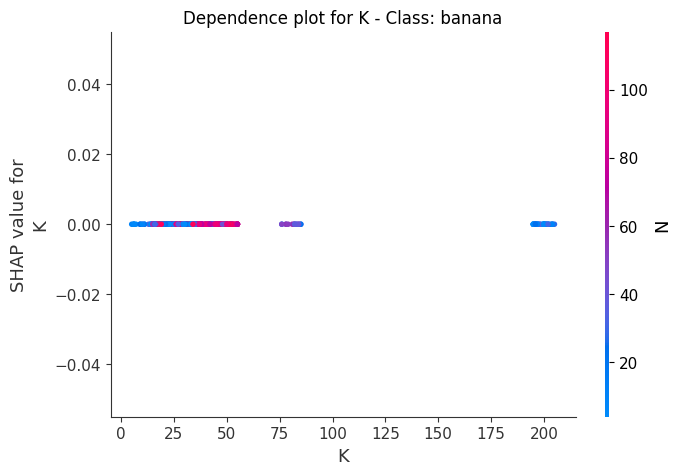

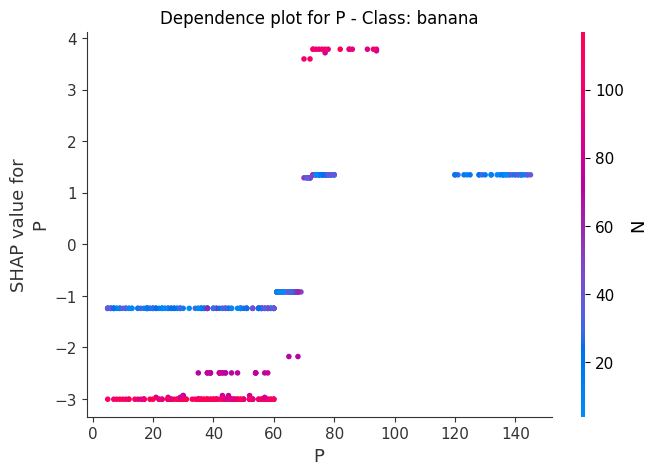

Class 2 (blackgram)


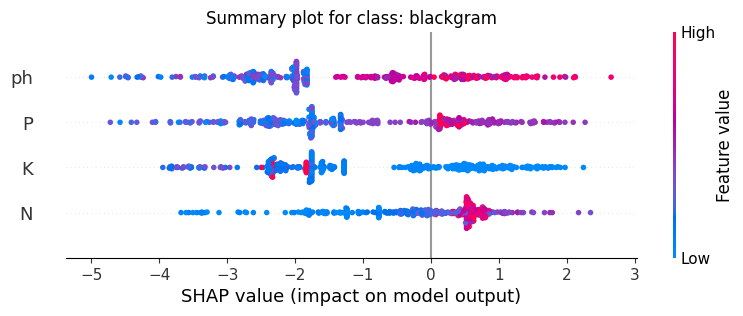

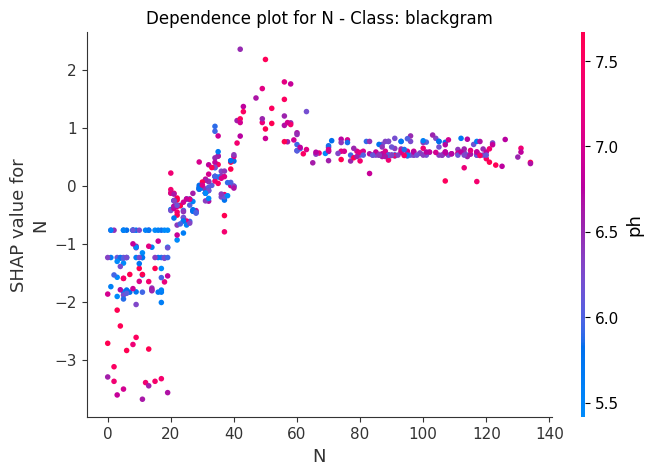

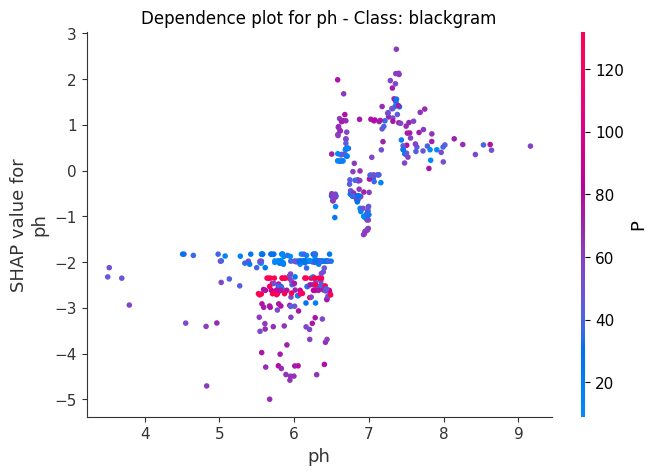

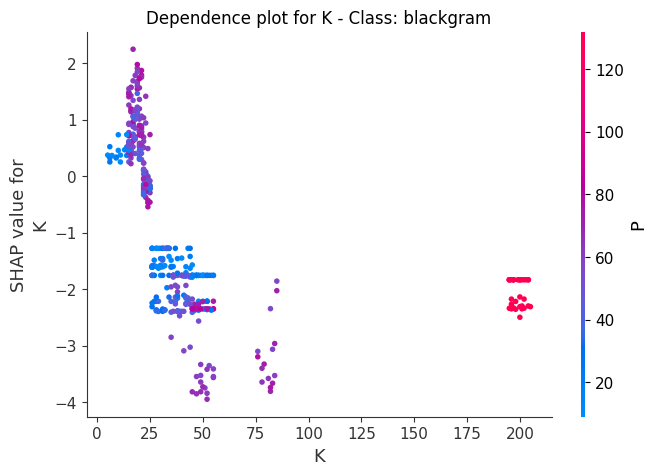

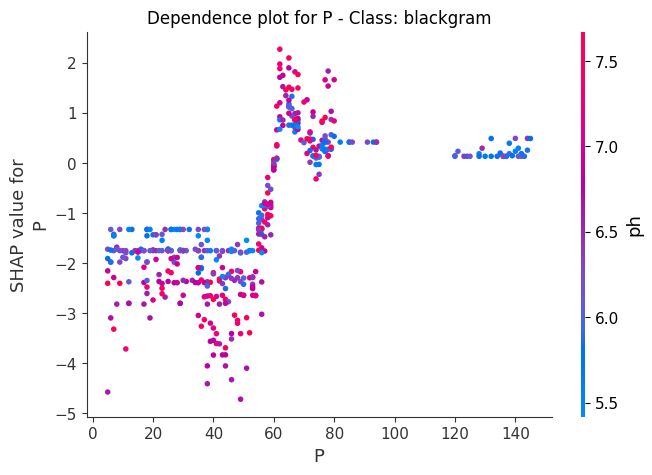

Class 3 (chickpea)


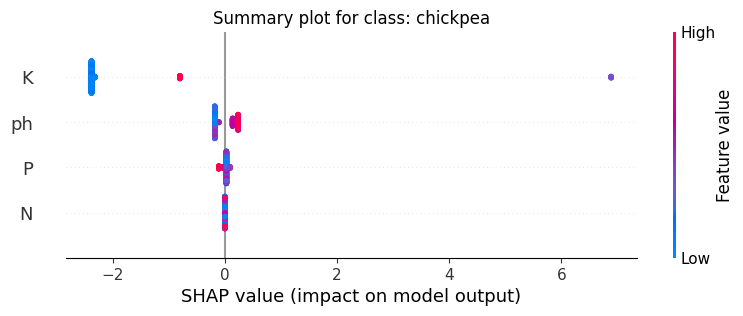

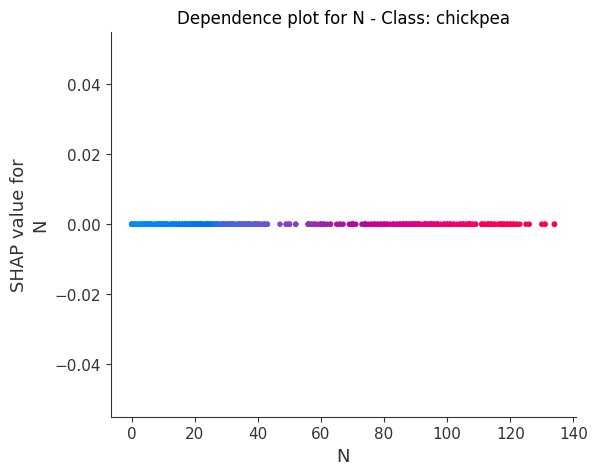

c:\Users\Hande\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hande\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


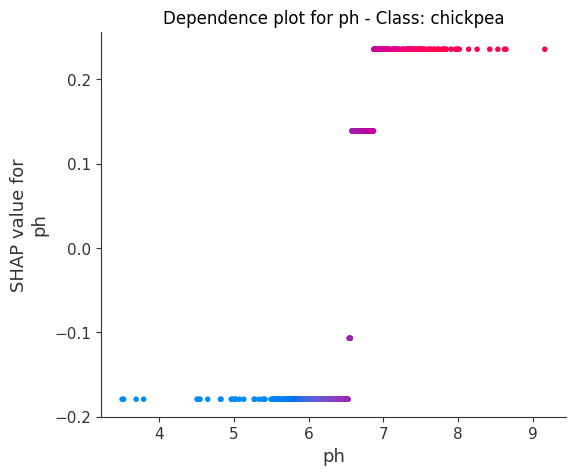

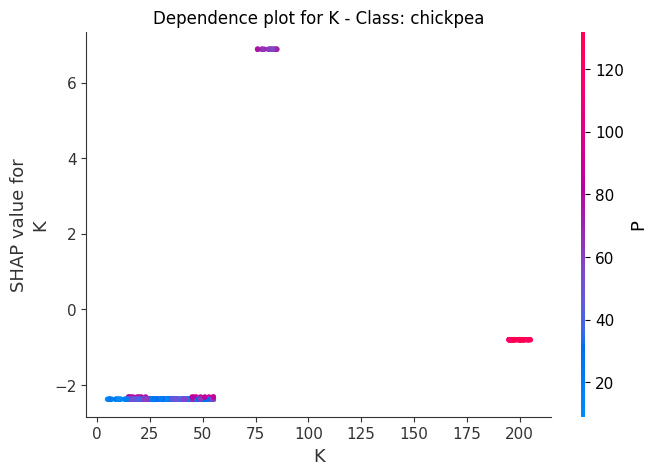

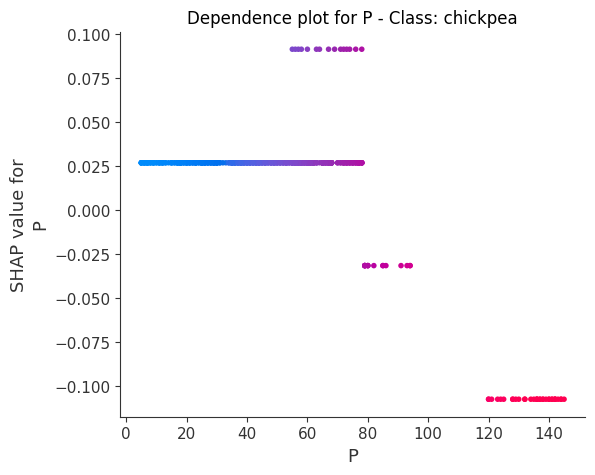

Class 4 (coconut)


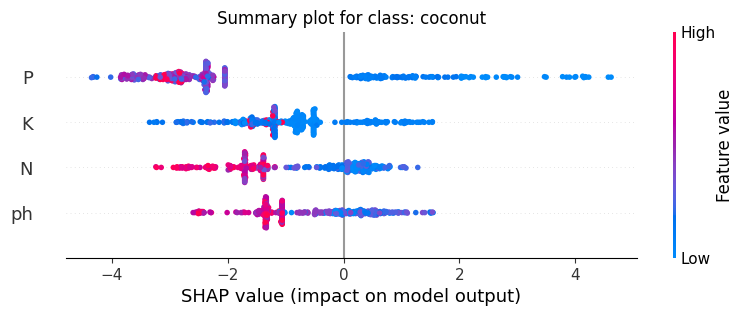

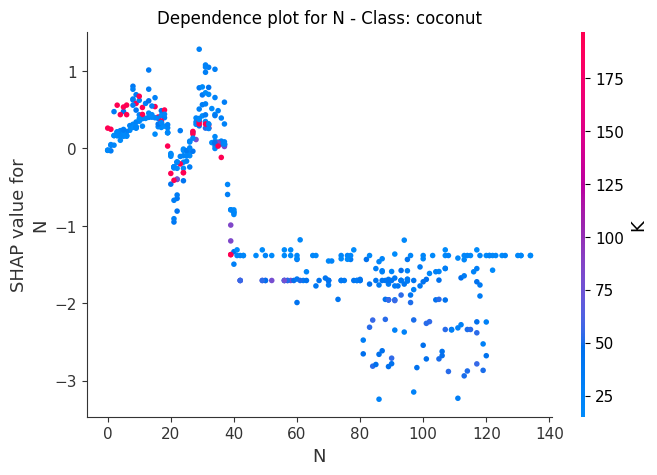

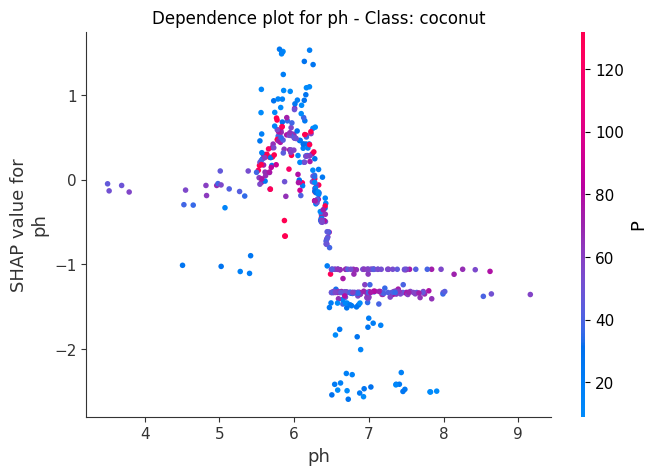

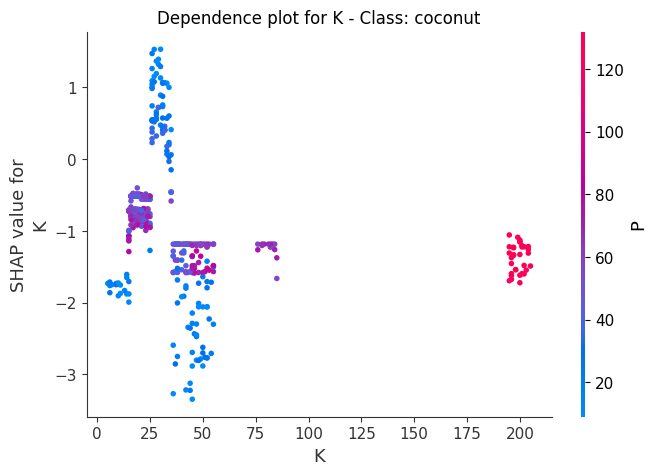

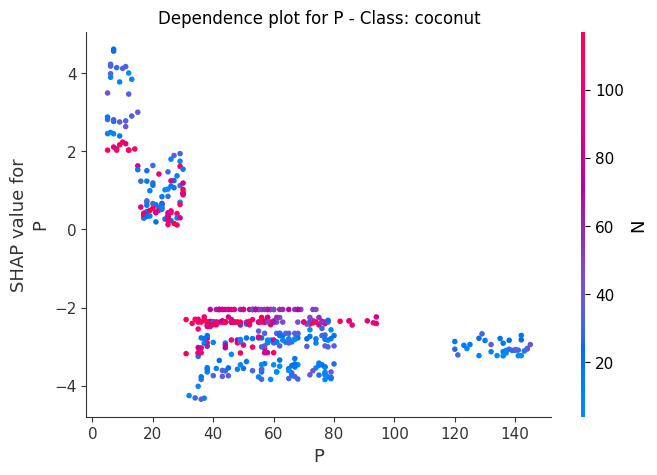

Class 5 (coffee)


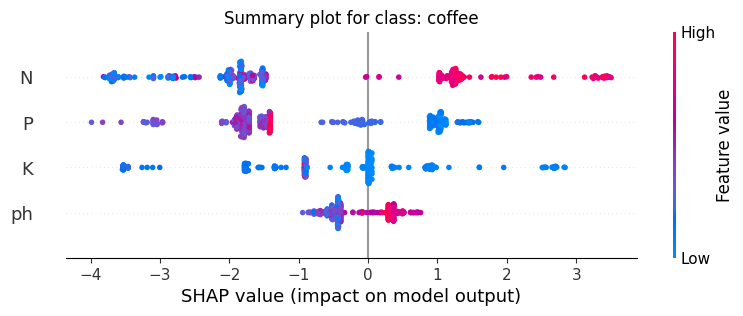

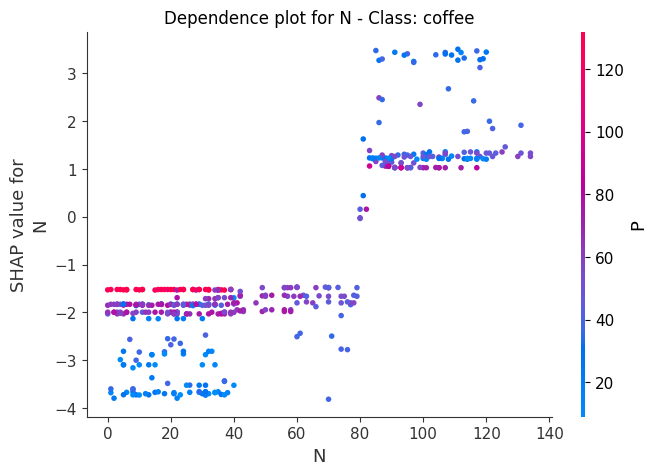

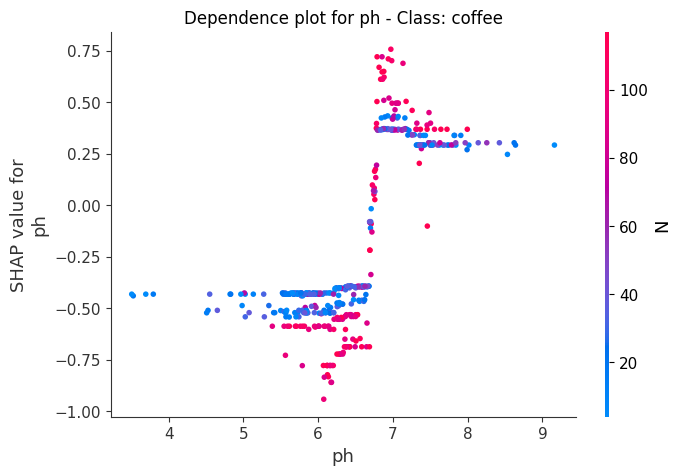

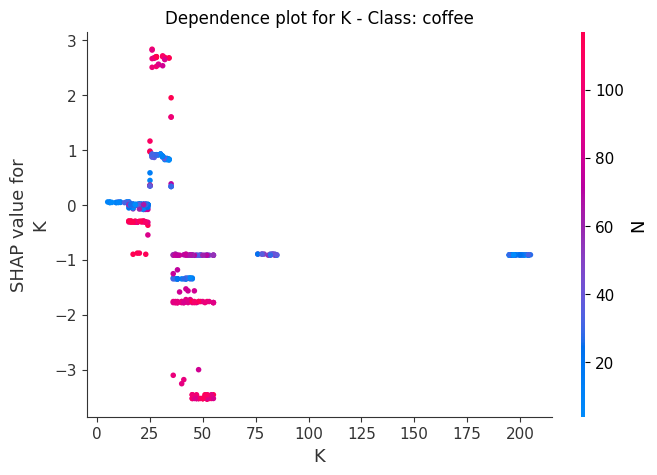

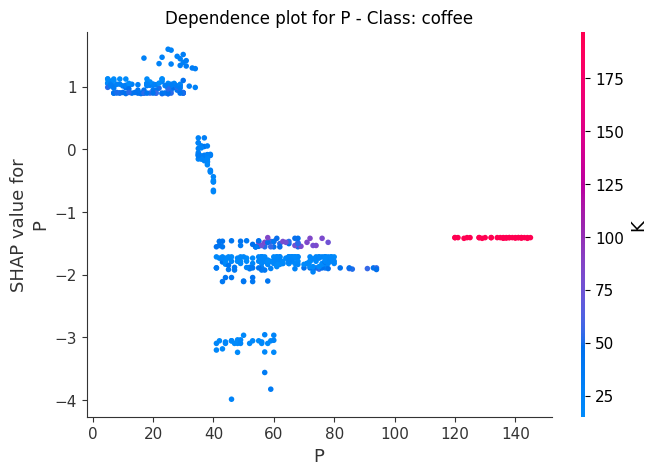

Class 6 (cotton)


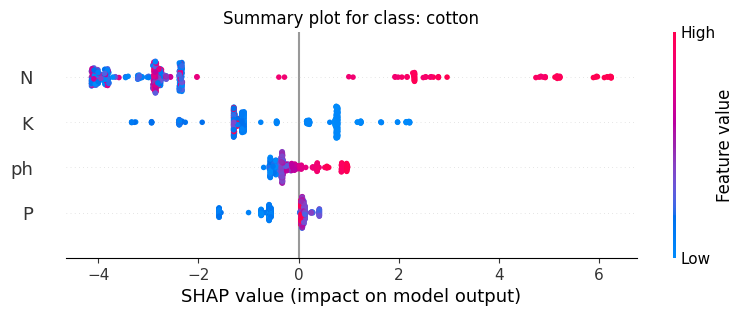

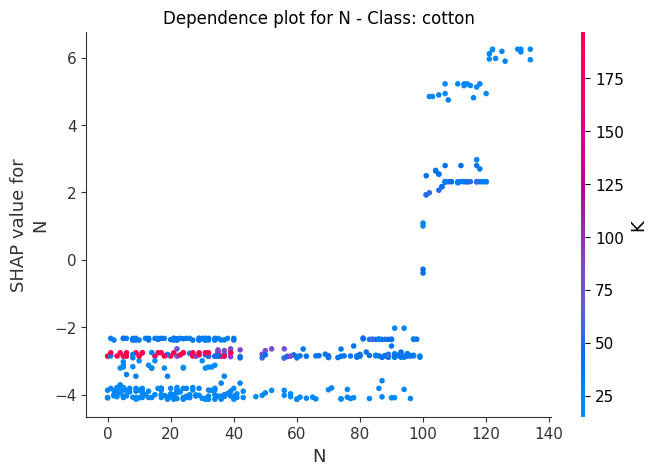

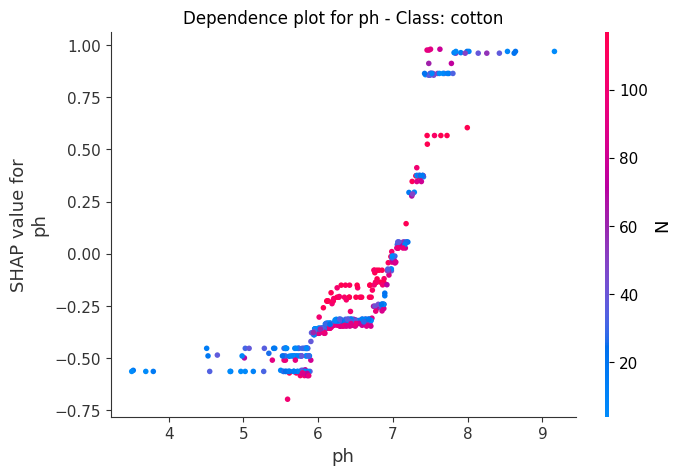

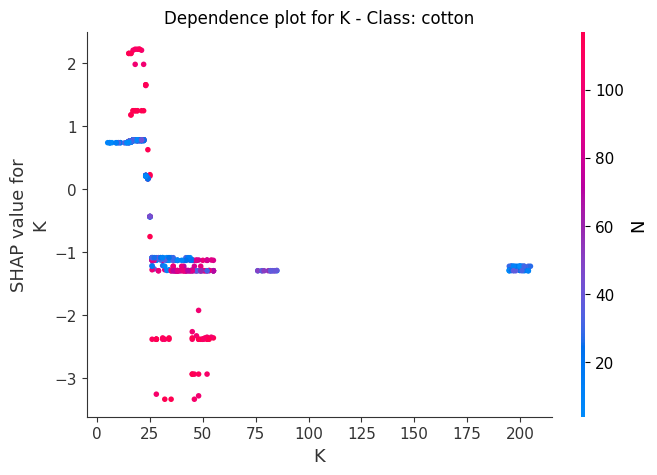

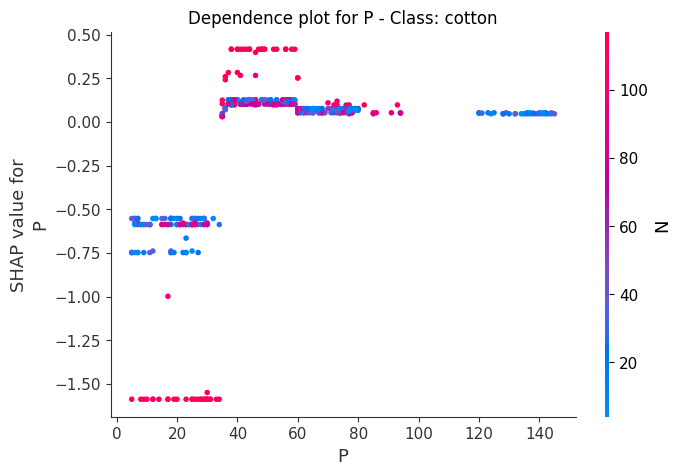

Class 7 (grapes)


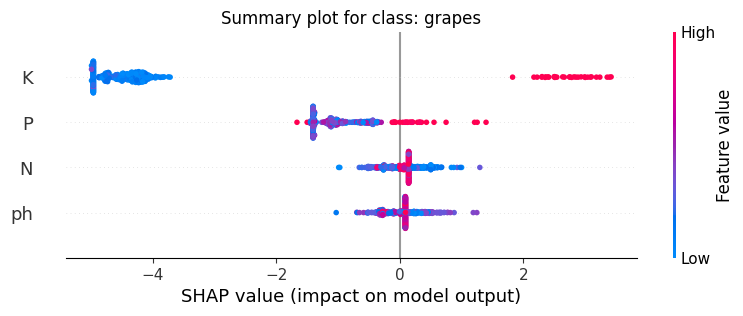

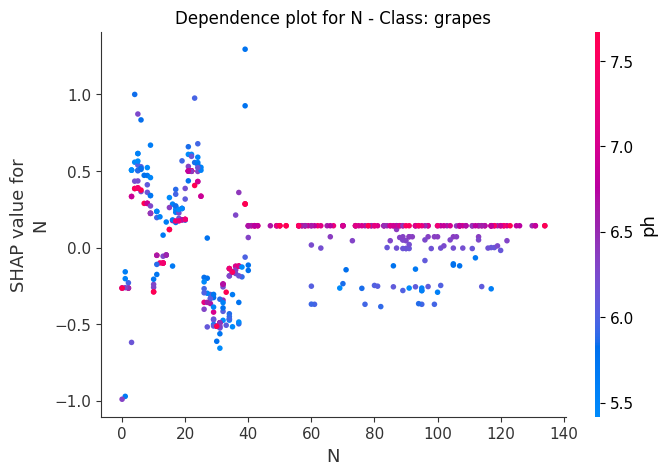

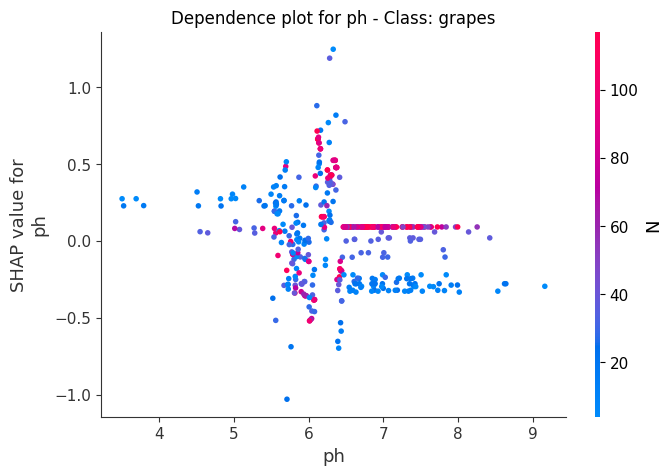

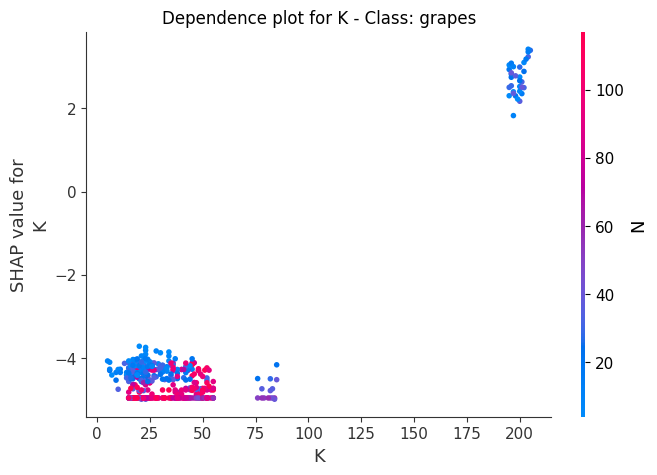

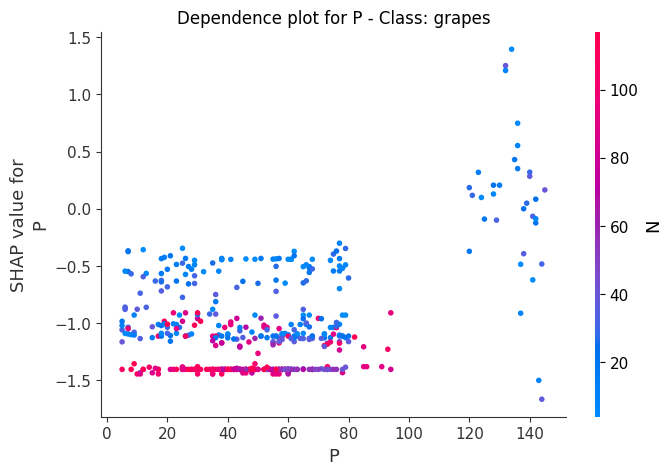

Class 8 (jute)


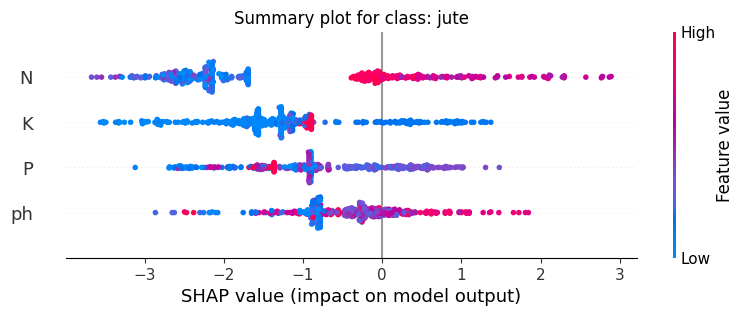

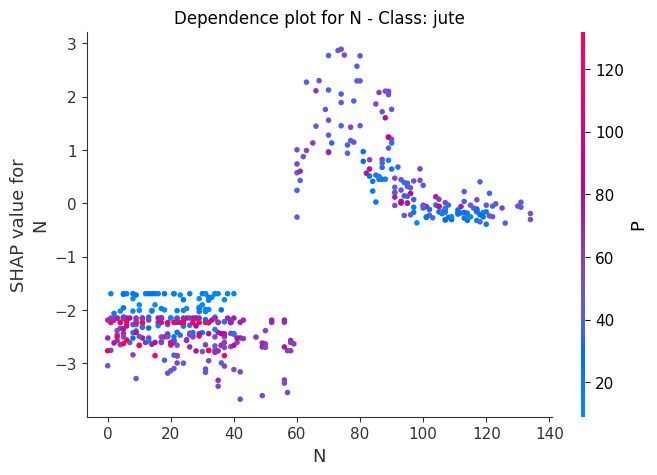

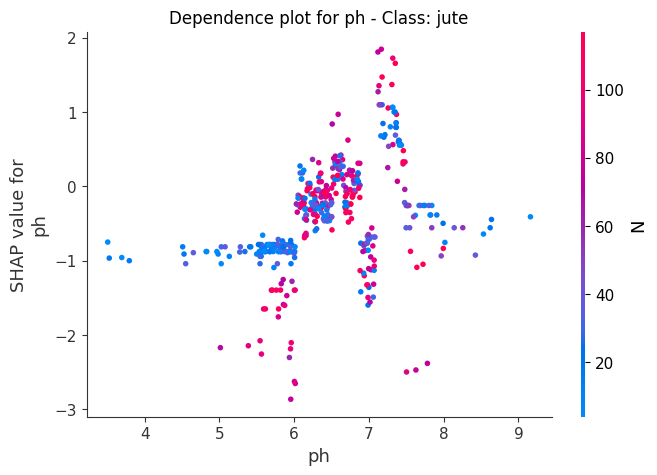

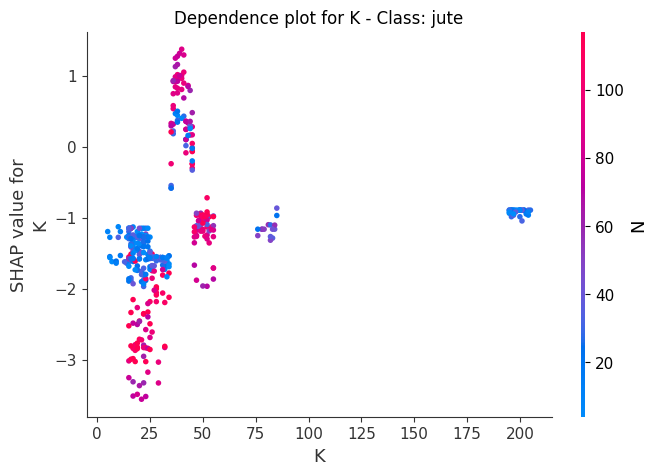

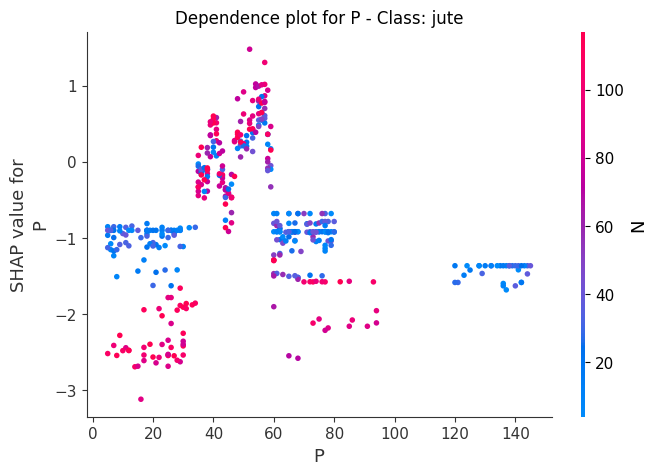

Class 9 (kidneybeans)


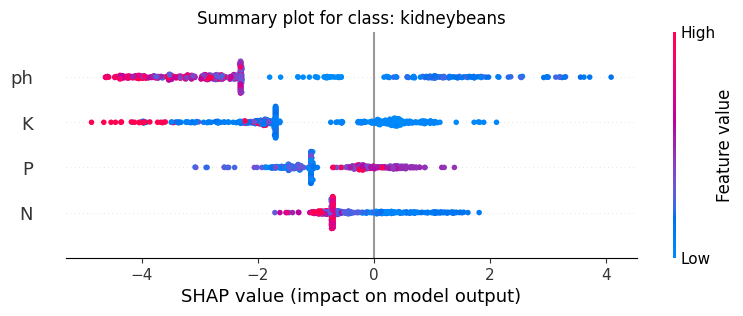

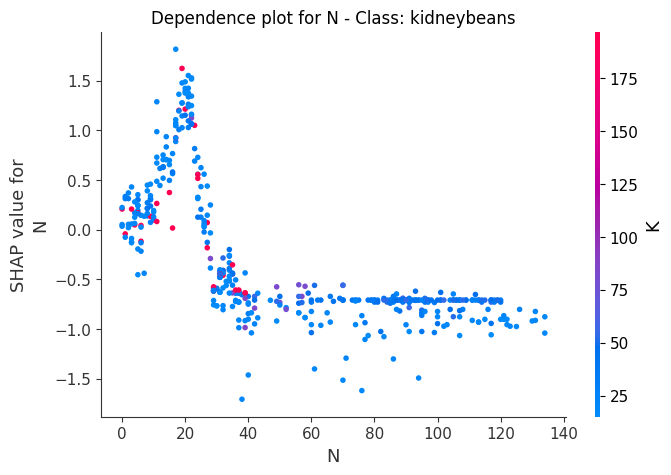

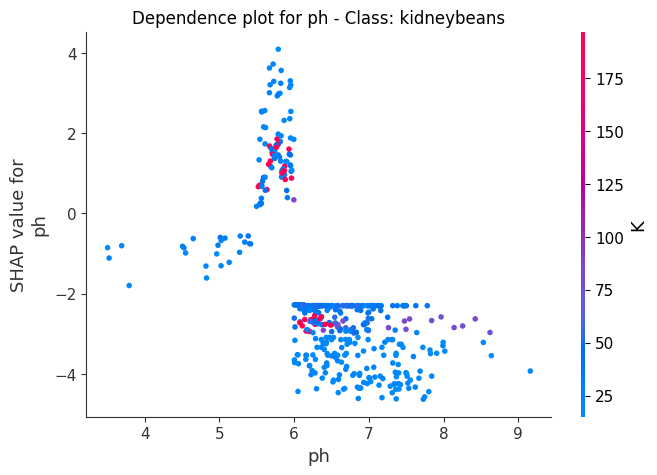

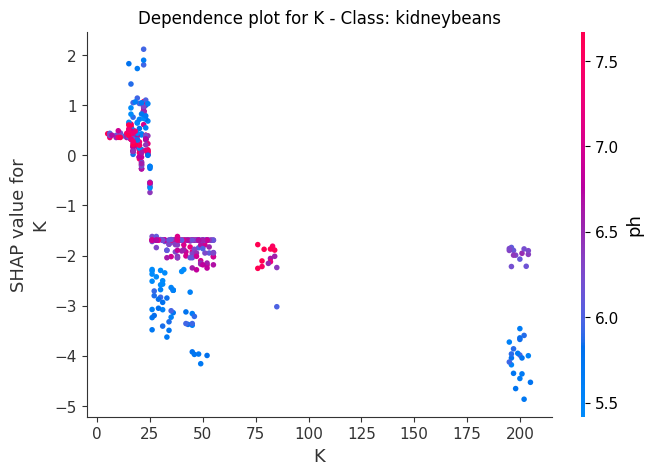

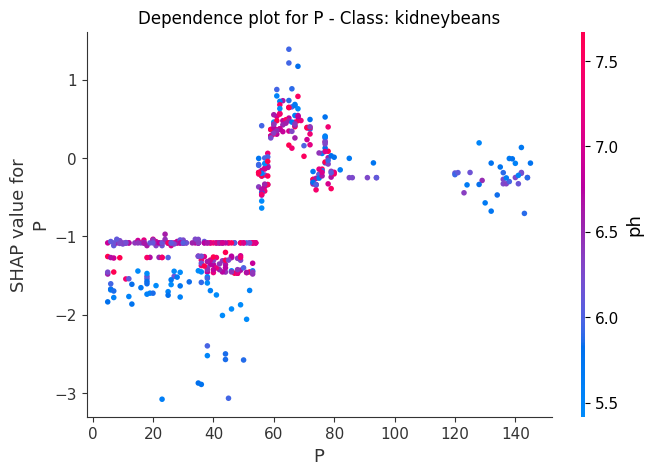

Class 10 (lentil)


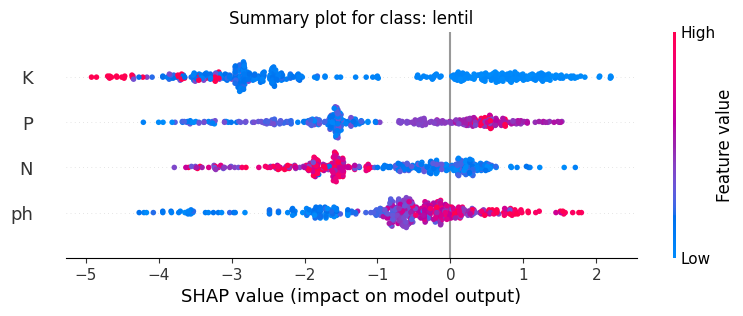

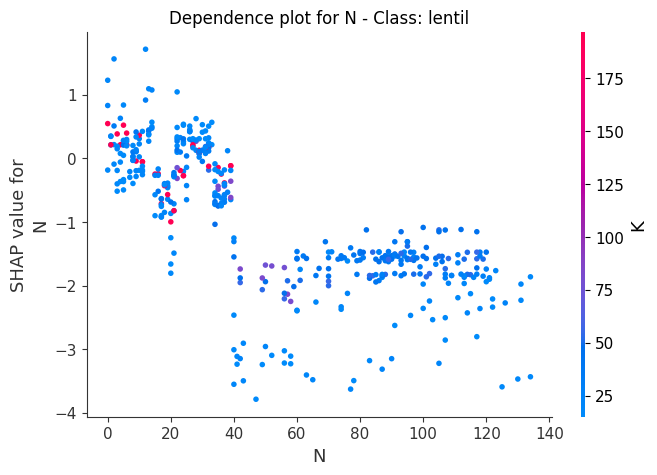

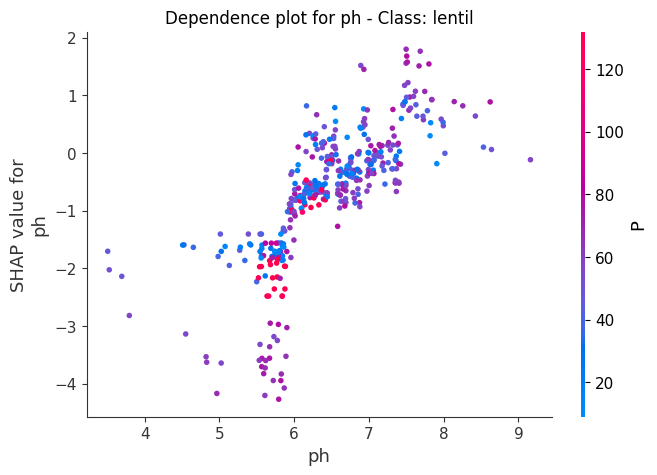

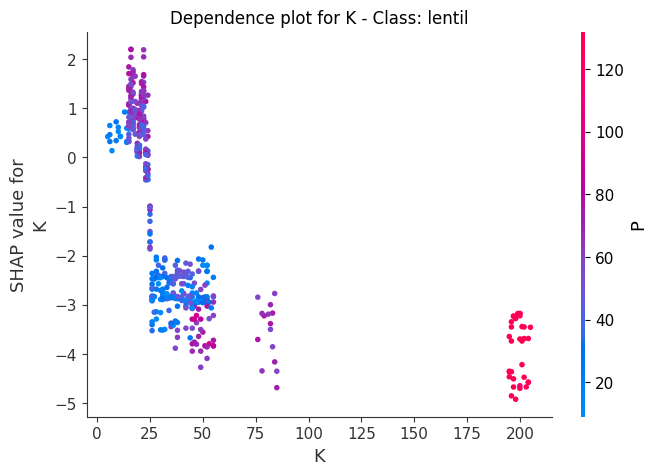

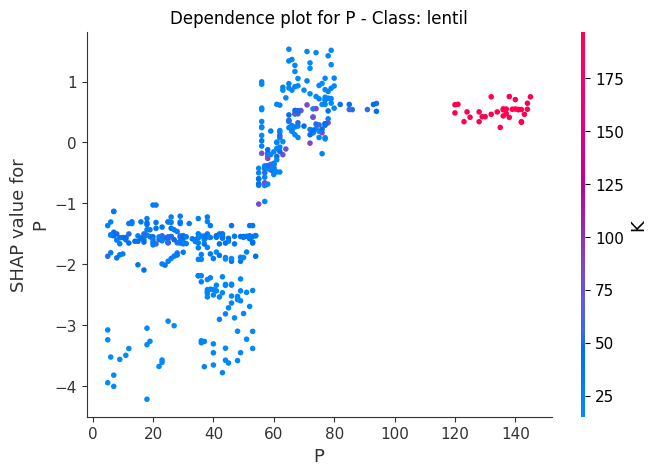

Class 11 (maize)


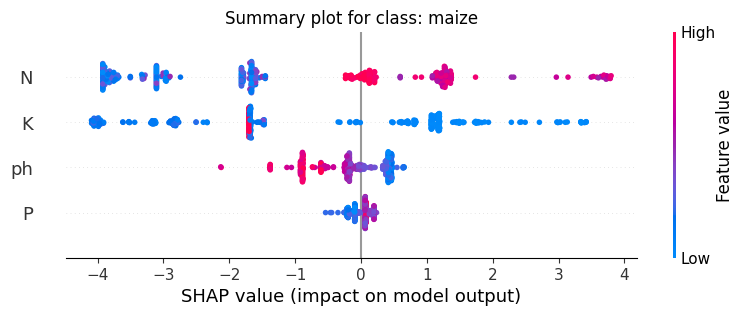

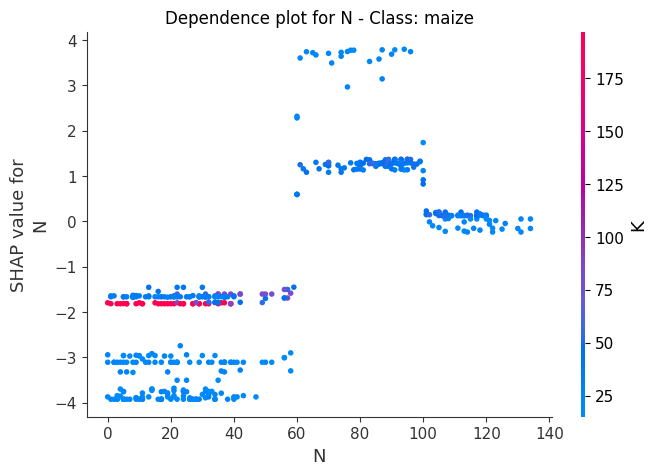

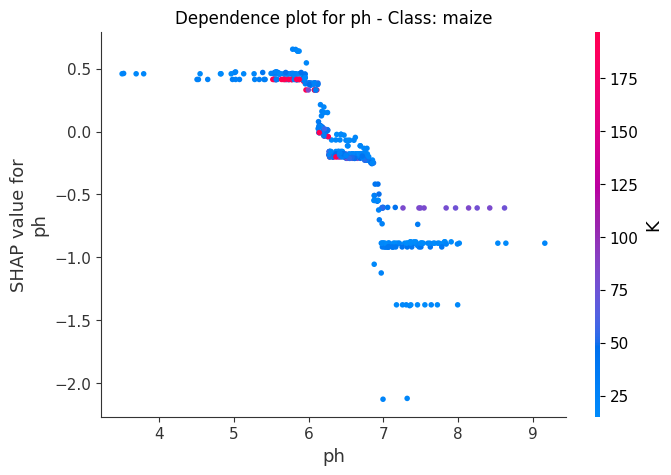

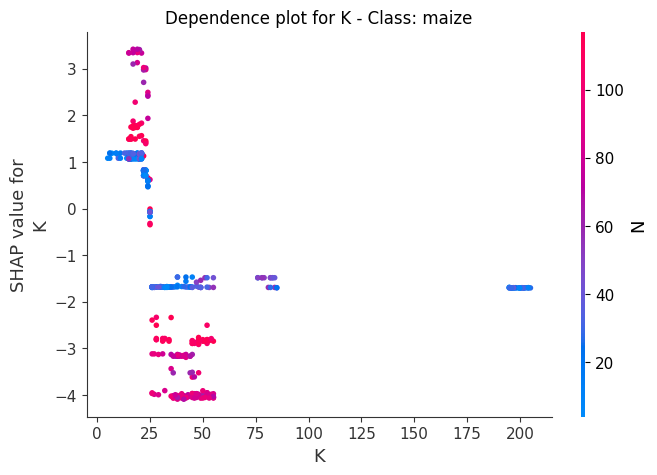

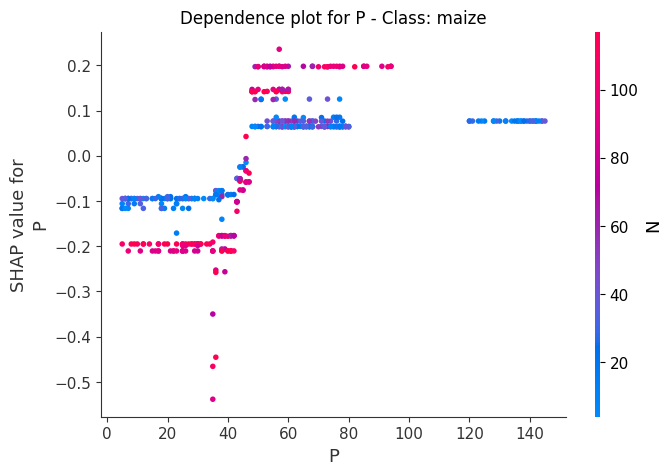

Class 12 (mango)


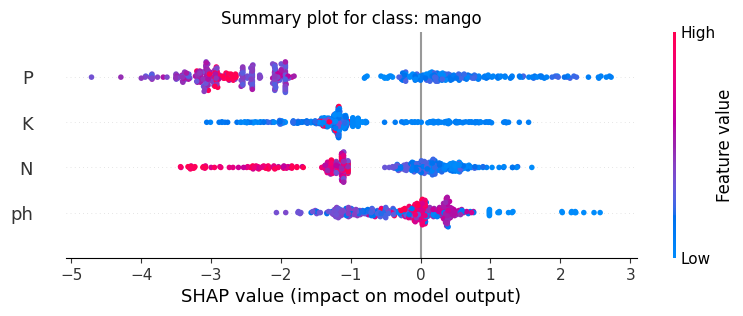

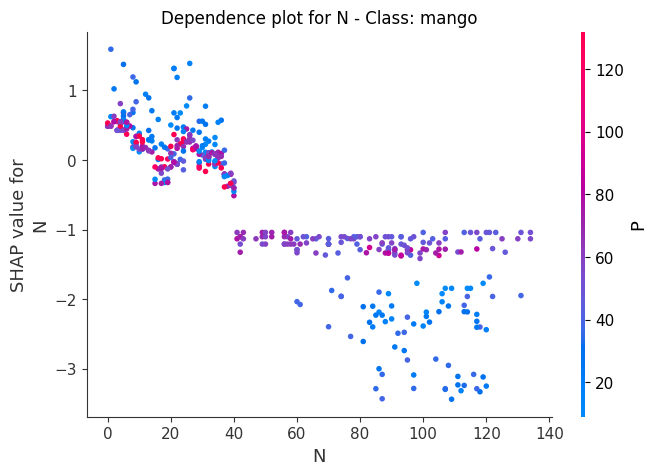

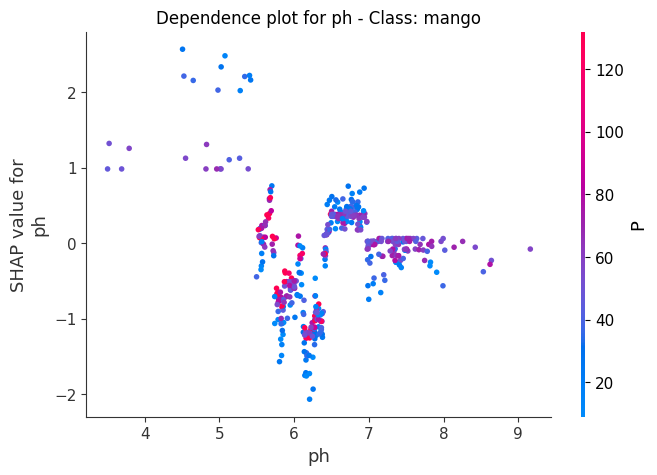

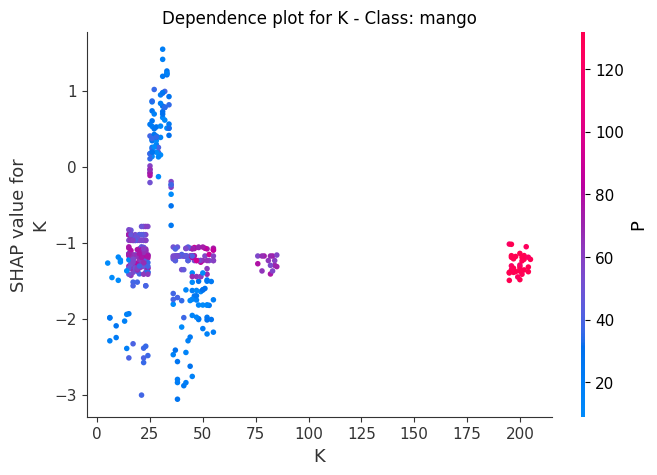

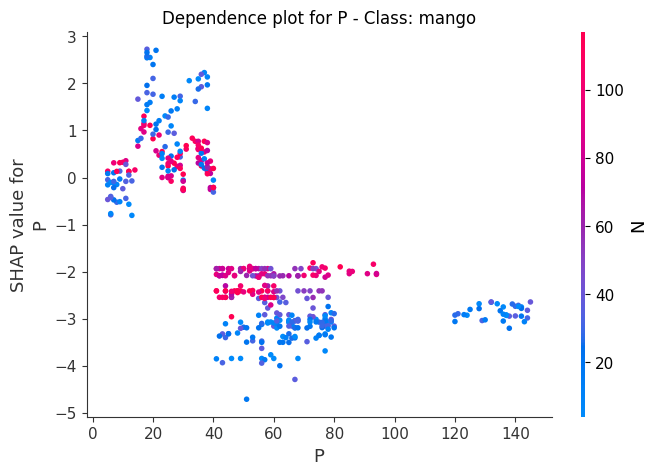

Class 13 (mothbeans)


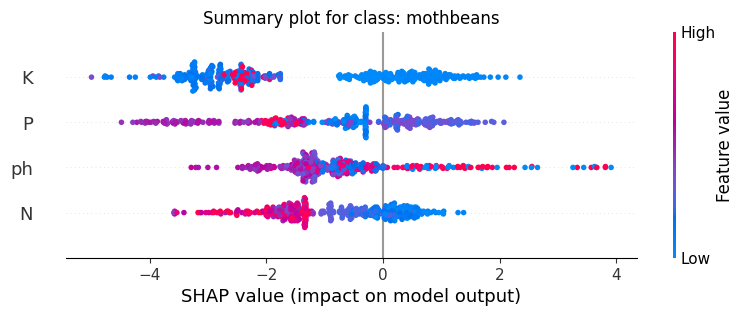

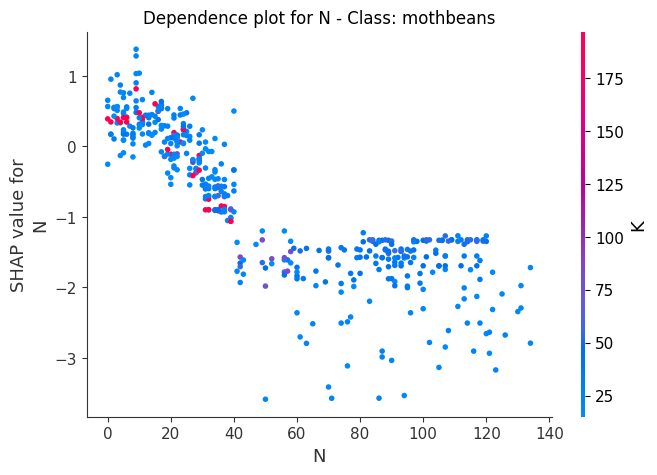

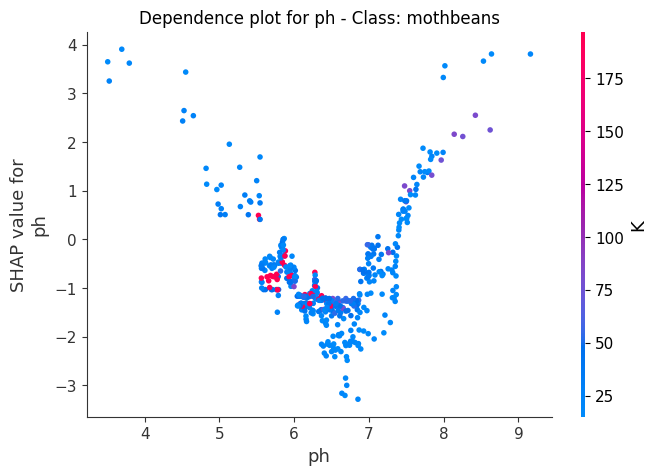

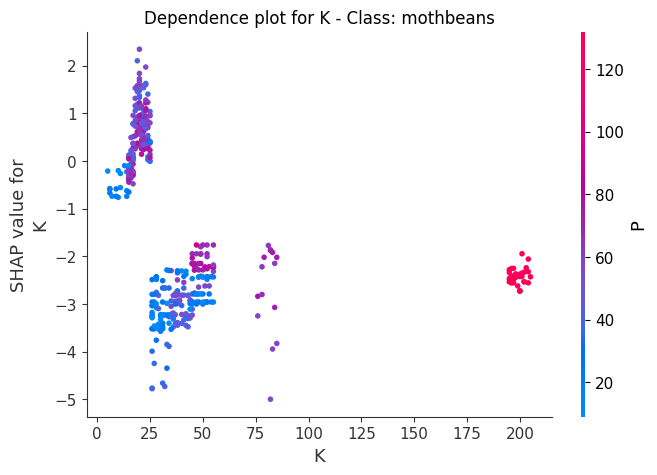

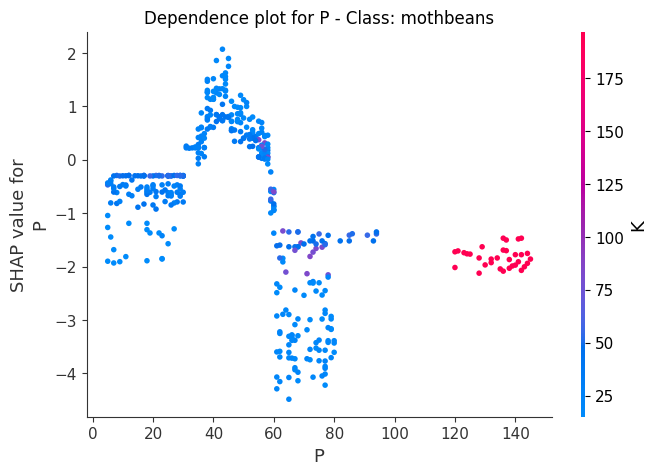

Class 14 (mungbean)


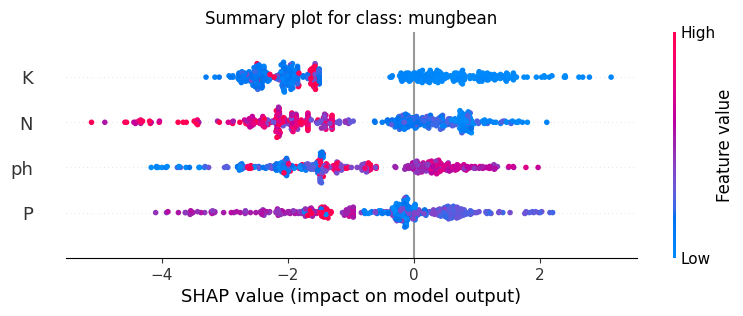

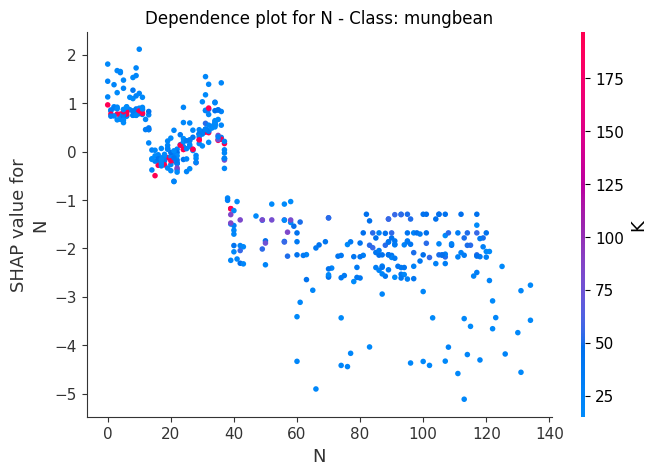

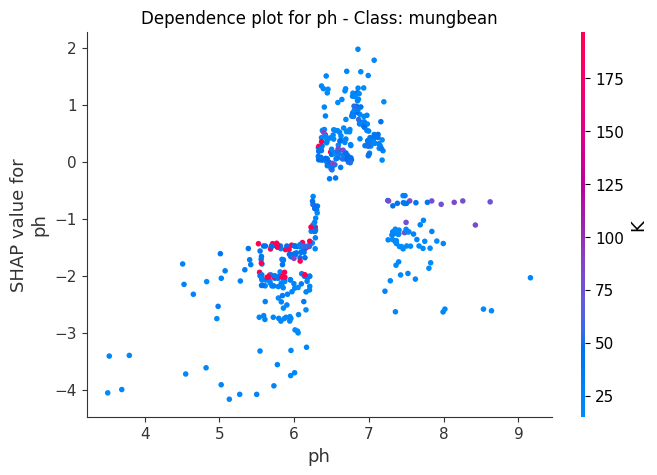

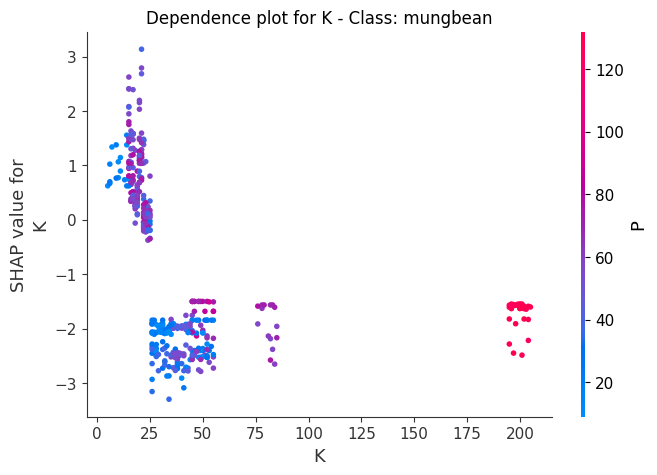

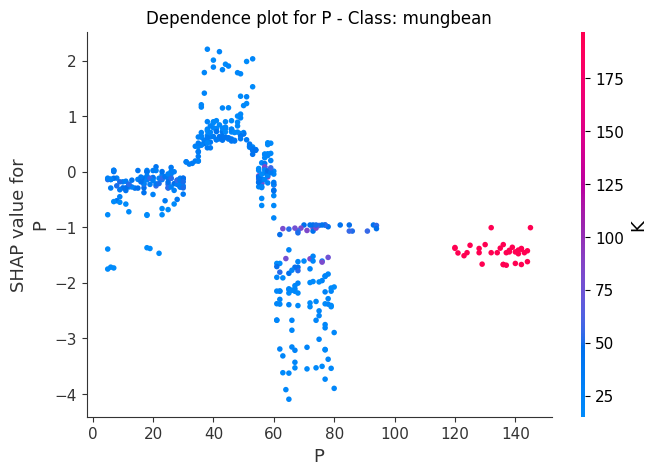

Class 15 (muskmelon)


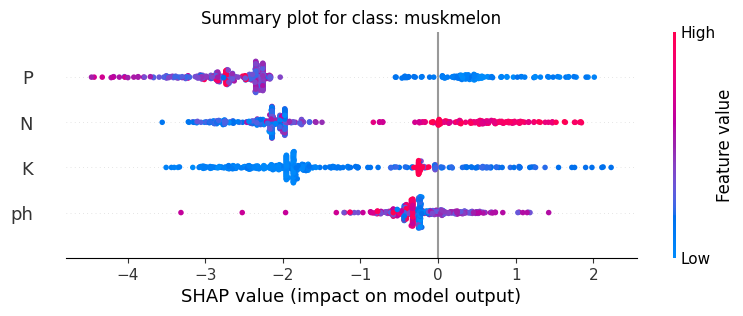

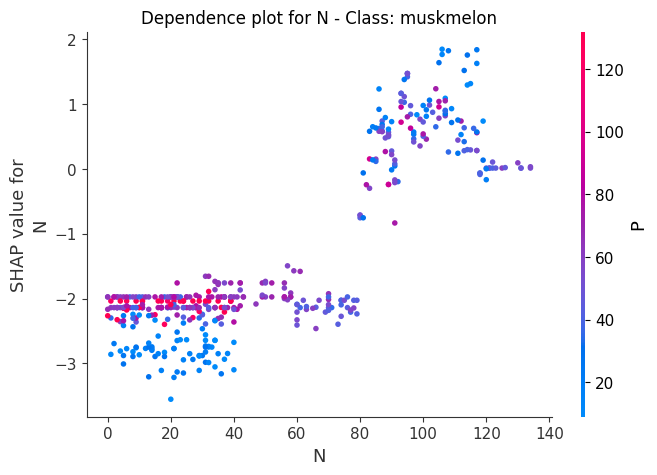

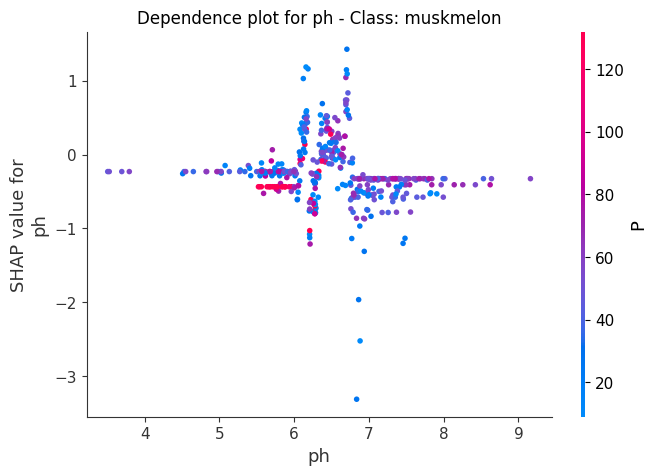

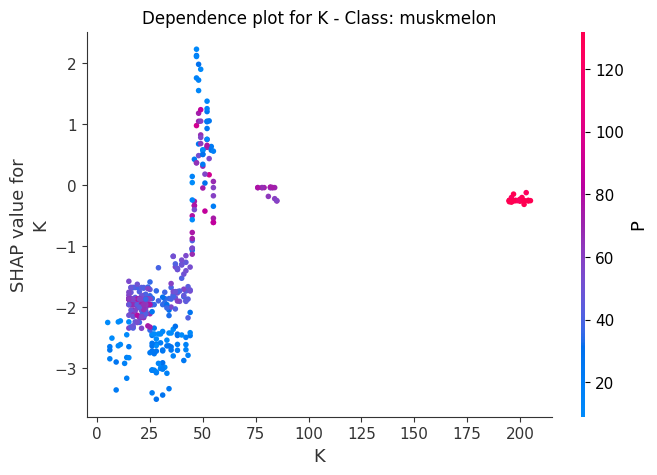

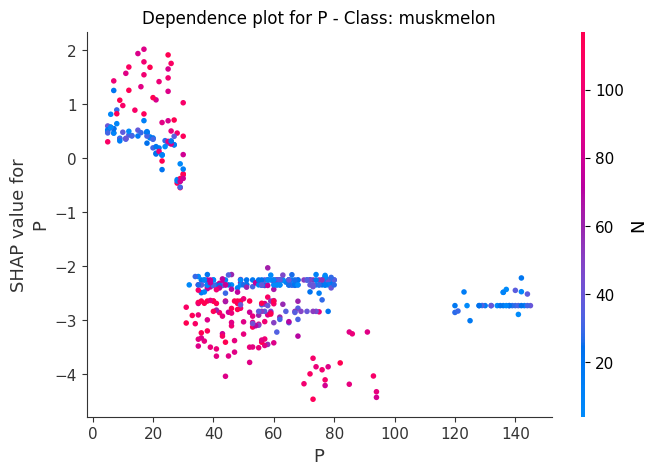

Class 16 (orange)


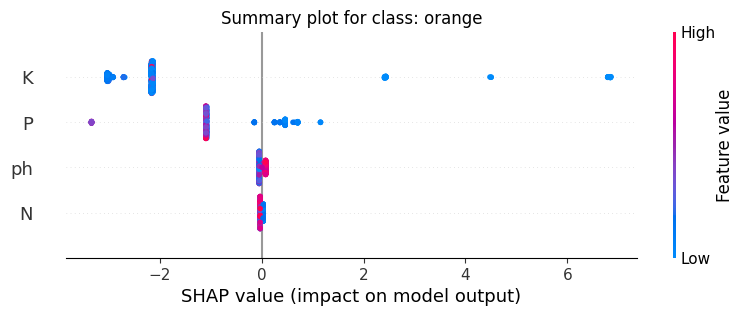

c:\Users\Hande\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hande\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


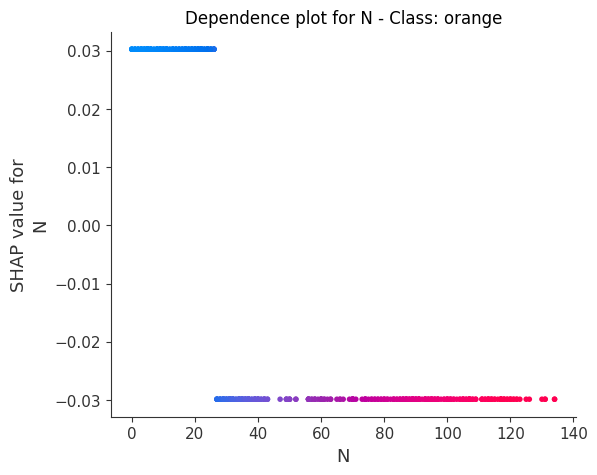

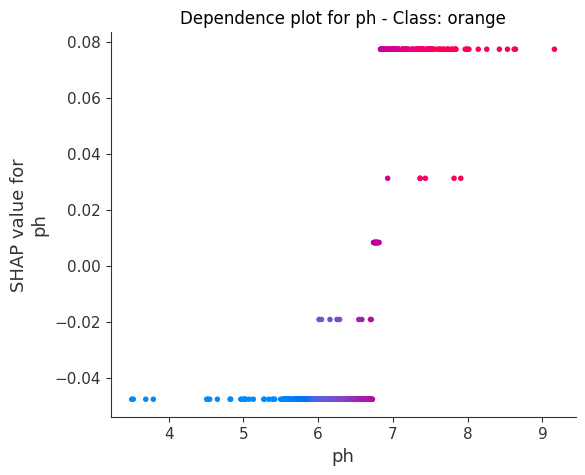

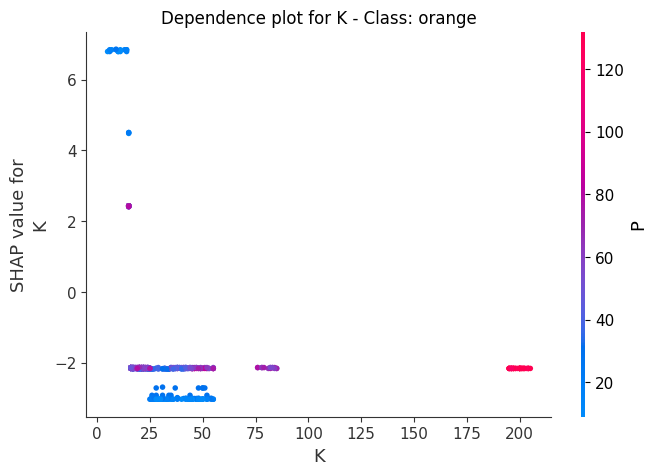

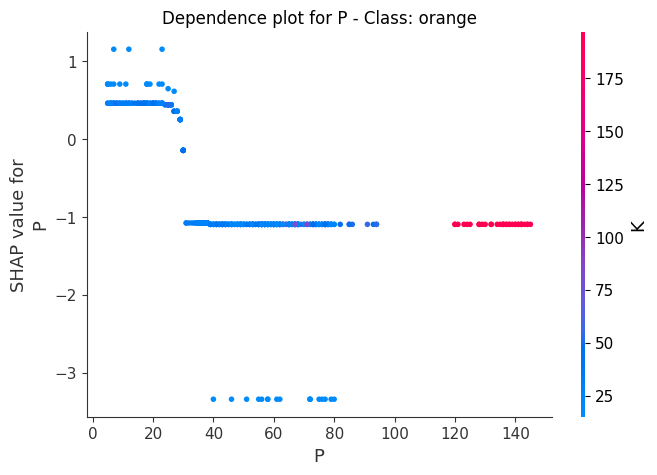

Class 17 (papaya)


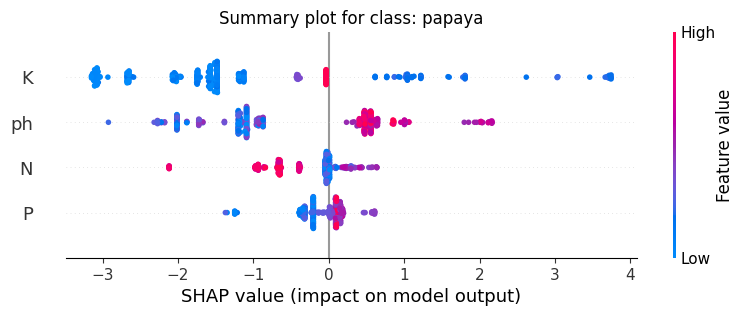

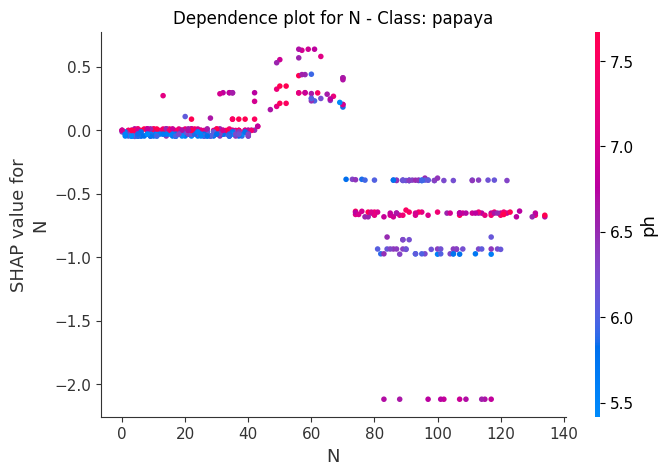

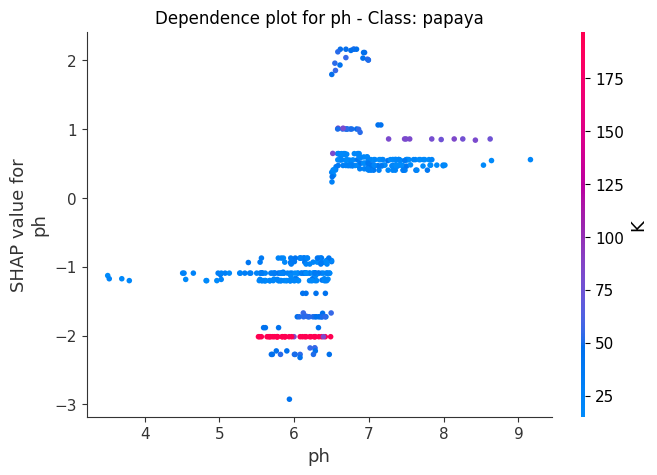

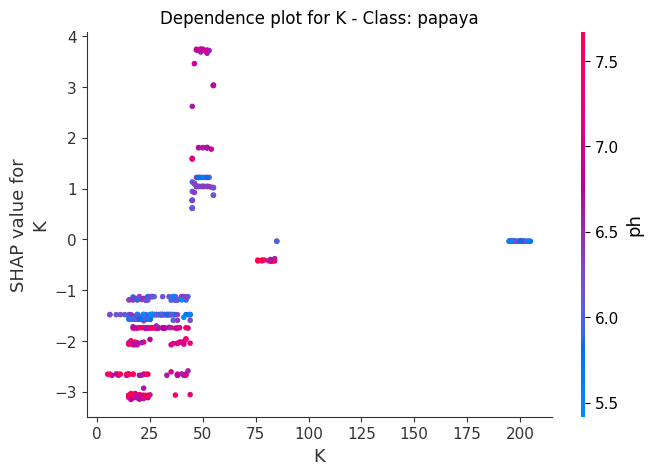

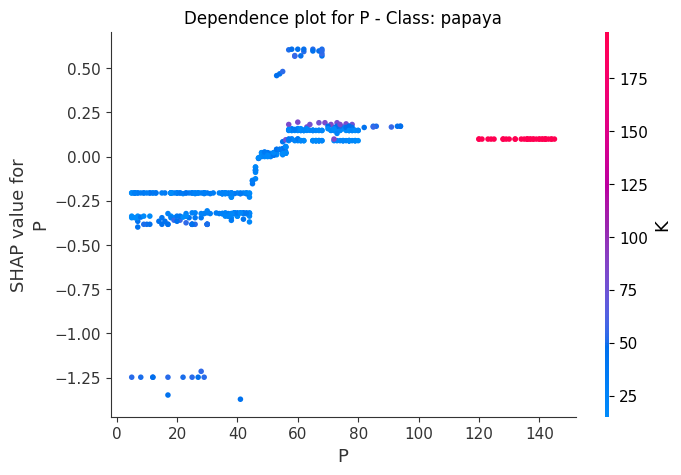

Class 18 (pigeonpeas)


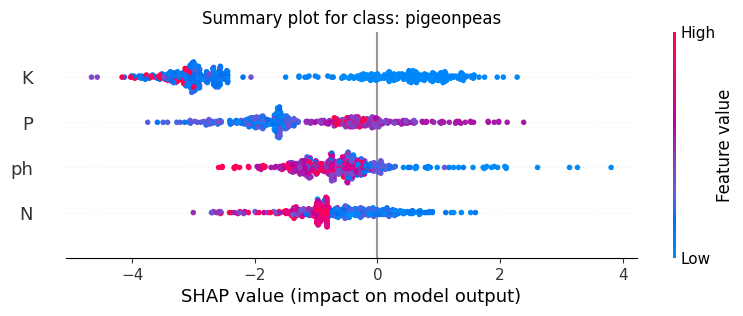

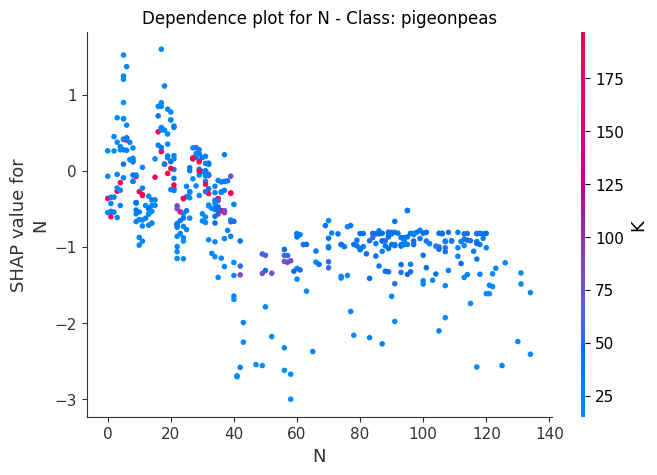

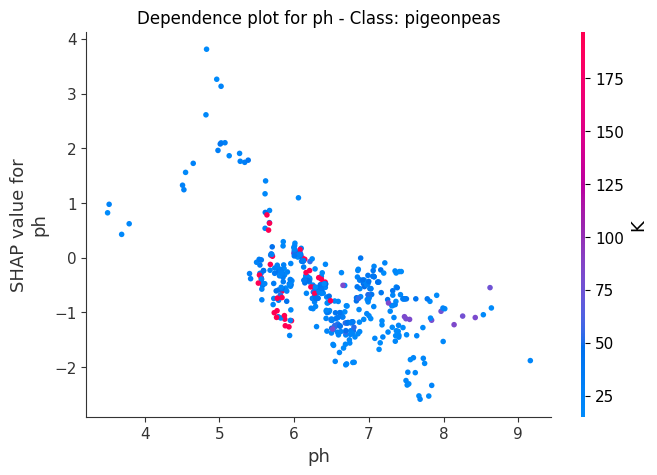

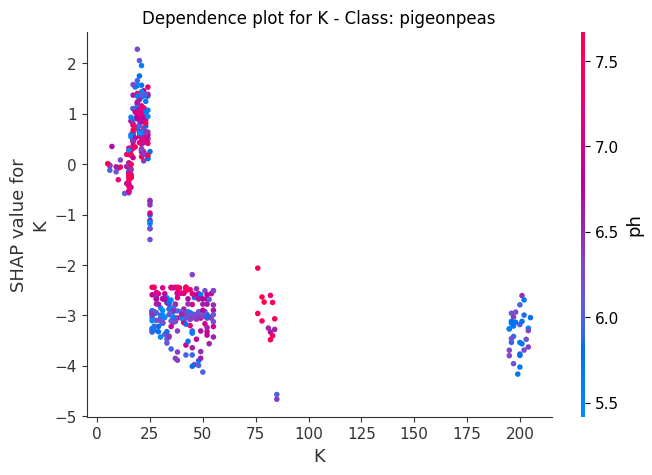

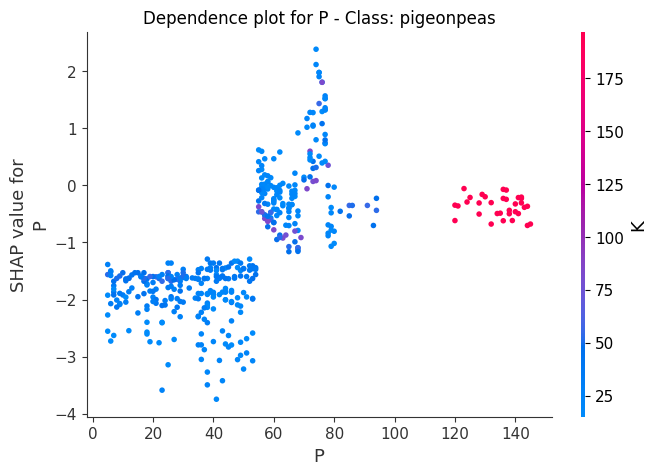

Class 19 (pomegranate)


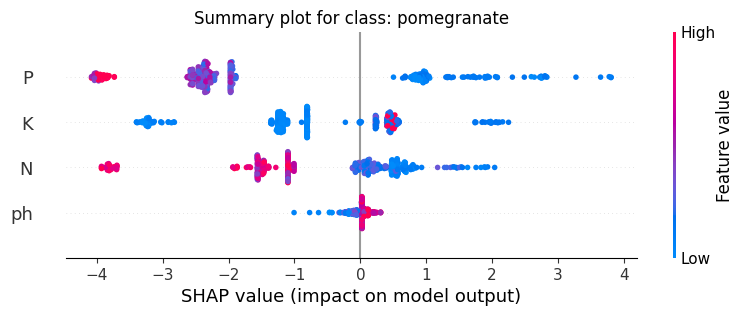

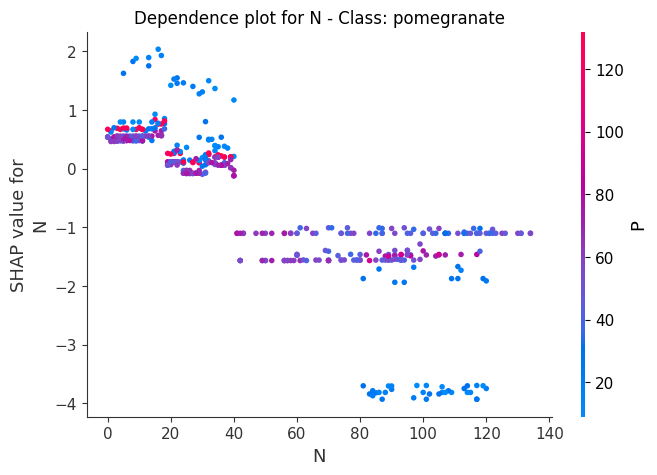

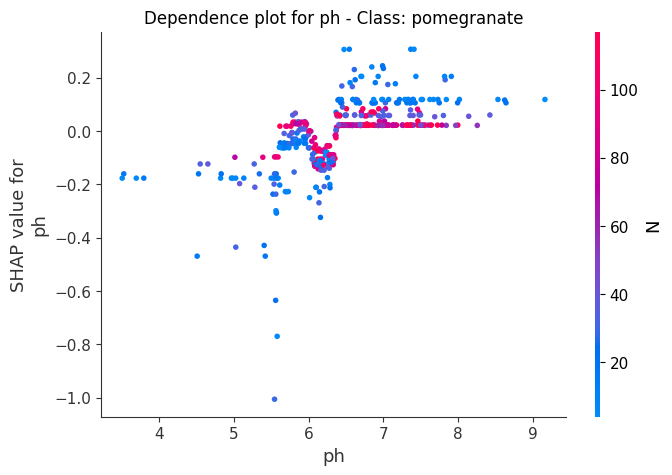

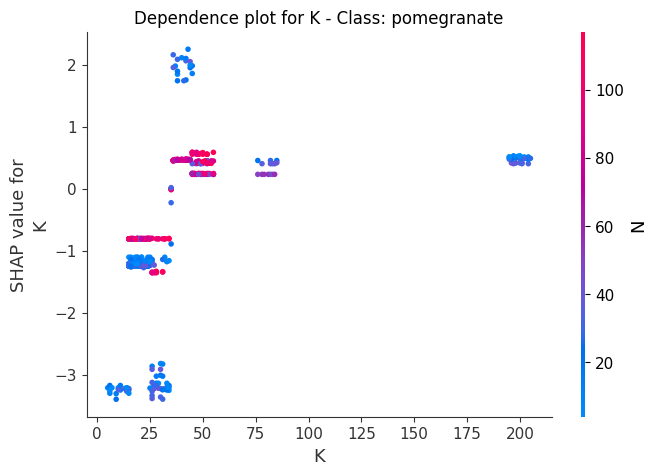

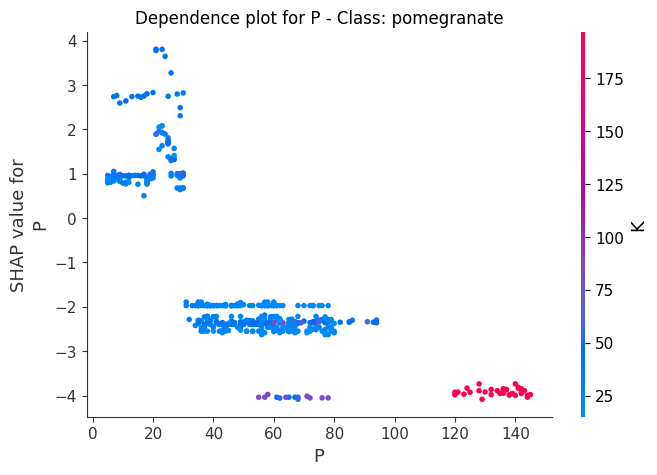

Class 20 (rice)


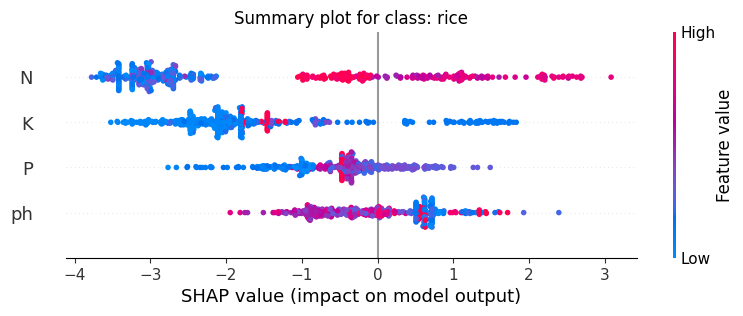

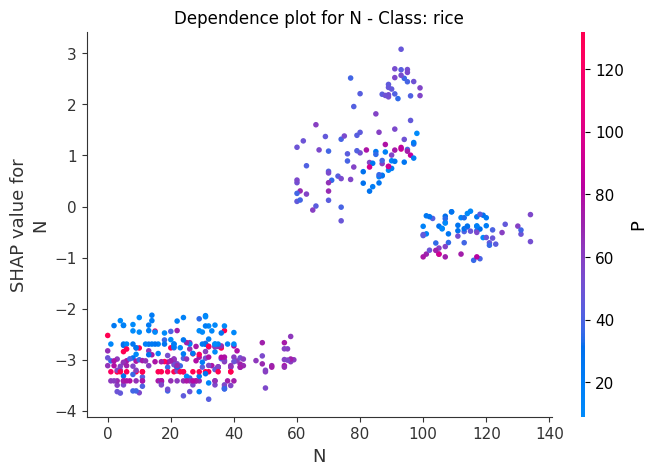

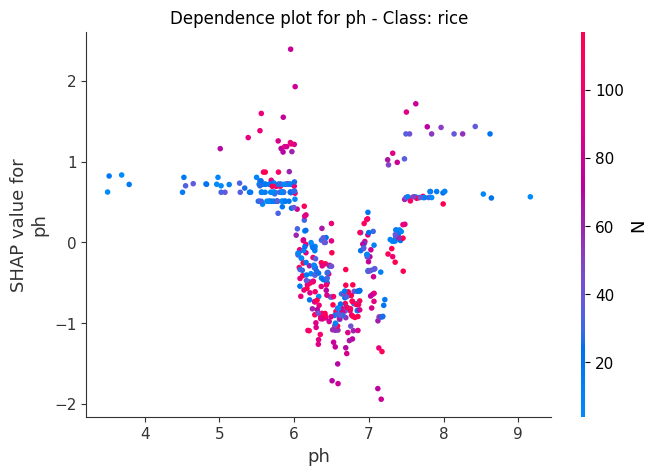

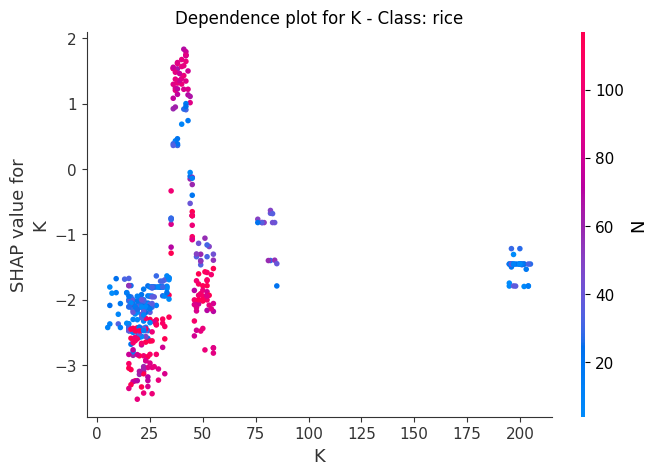

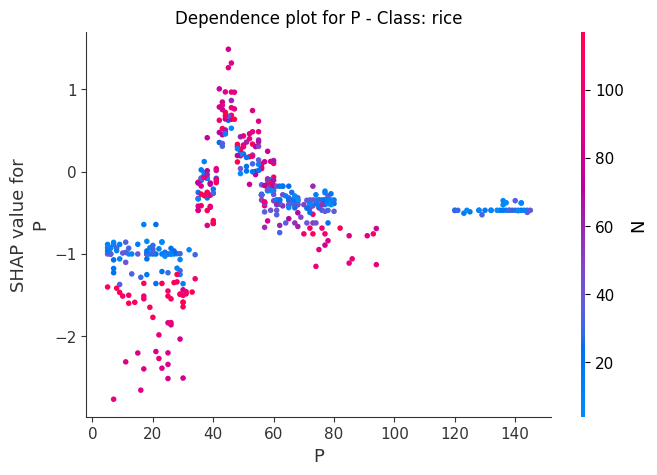

Class 21 (watermelon)


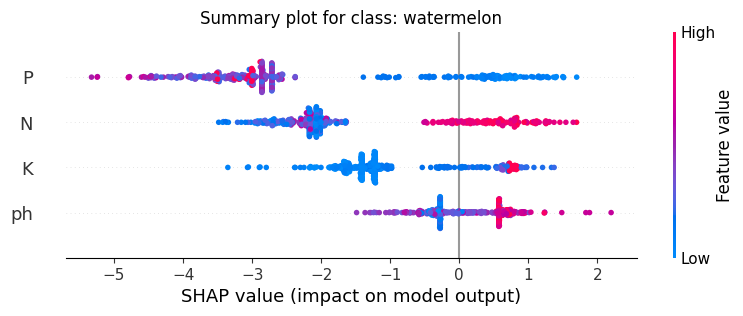

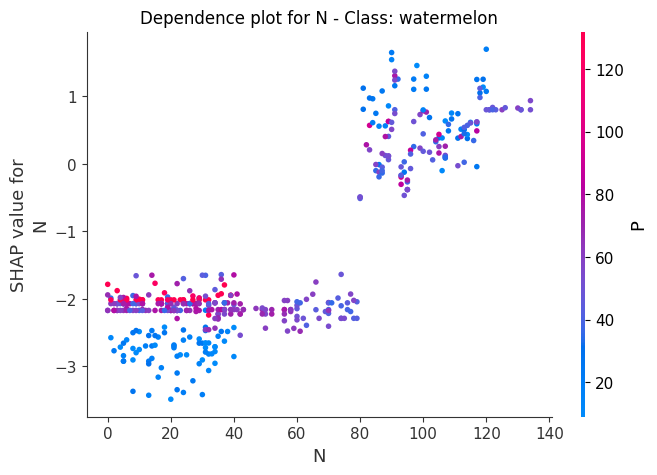

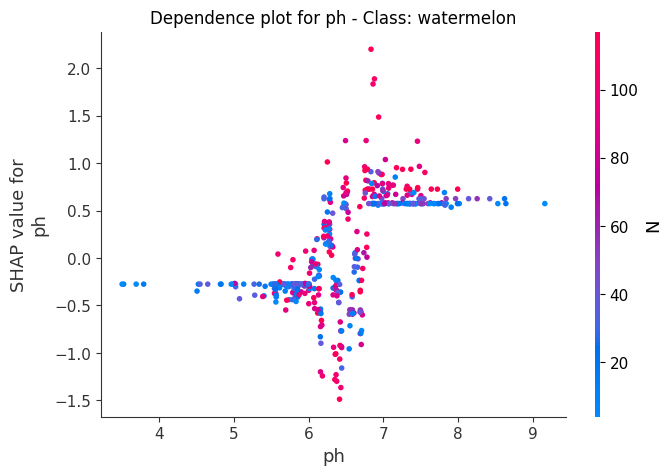

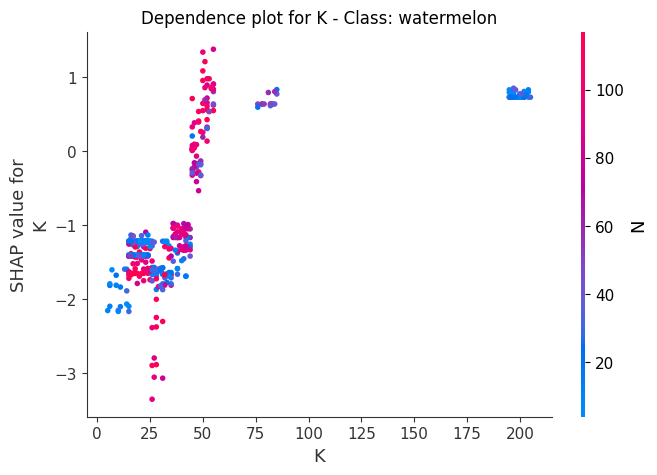

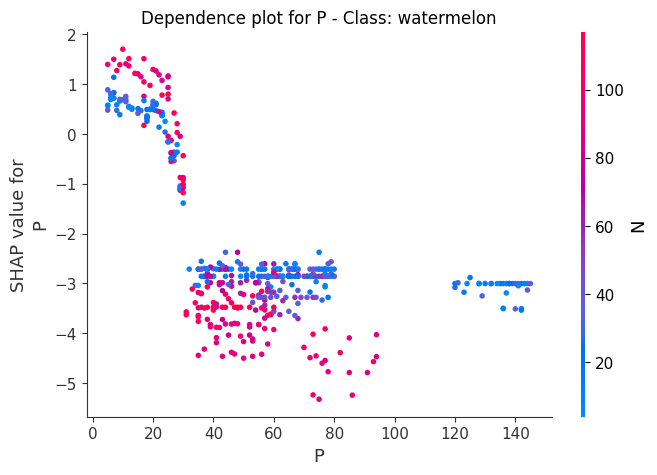

In [26]:

# Analyze SHAP values for XGBoost to understand feature importance per crop
explainer = shap.TreeExplainer(fitted_xgb)
shap_values = explainer.shap_values(X_test)

# Debugging: shapes
print(f"Shape of shap_values: {shap_values.shape}")
print(f"Shape of X_test: {X_test.shape}")

# Plot SHAP values for each class
for i in range(len(label_encoder.classes_)):
    class_name = label_encoder.classes_[i]
    print(f"Class {i} ({class_name})")

    # Summary plot for the class
    class_shap_values = shap_values[:, :, i]  # Isolate SHAP values for class i
    shap.summary_plot(class_shap_values, X_test, feature_names=final_features, show=False)
    plt.title(f"Summary plot for class: {class_name}")
    plt.show()

    # Dependence plots for each feature in the class
    for j, feature in enumerate(final_features):
        shap.dependence_plot(j, class_shap_values, X_test, feature_names=final_features, show=False)
        plt.title(f"Dependence plot for {feature} - Class: {class_name}")
        plt.show()